# Setup

Load libraries, set matplotlib to inline plotting, and create constants for analysis

In [1]:
%matplotlib inline

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import pyodbc as db
import numpy as np

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import seaborn as sns

# Set options
sns.set_style('darkgrid')
pd.set_option("display.max_rows", 10)

def get_filename(file_list):
    match = [s for s in file_list if "_rv" in s]
    answer = file_list[0]
    if len(match) > 0:
        answer = match[0]
    return(answer)

def net_load_info(url):
    resp = urlopen(url)
    zipfile = ZipFile(BytesIO(resp.read()))
    files = zipfile.namelist()
    return(files)

def net_load_data(url):
    resp = urlopen(url)
    zipfile = ZipFile(BytesIO(resp.read()))
    file_name = get_filename(zipfile.namelist())
    data_file = zipfile.open(file_name)
    answer = pd.read_csv(data_file,
                         low_memory = False,
                         encoding = "iso-8859-1")
    
    return(answer)

def fix_cols(dat):
    for col in dat:
        col = col.lower()
        dat[col] = pd.to_numeric(dat[col], errors = "coerce", downcast = "integer")
    return(dat)

def read_file(year, keepers):
    file_spec = np.where(year < 2014, "ic" + str(year) + ".zip", "adm" + str(year) + ".zip")
    answer = net_load_data("https://nces.ed.gov/ipeds/datacenter/data/" + str(file_spec))
    answer.columns = [colname.lower() for colname in list(answer.columns.values)]
    answer = fix_cols(answer)
    answer["institution_key"] = answer["unitid"]
    answer["date_key"] = (year * 10000) + 1015
    answer = answer[keepers]
    return(answer)

# constants
start_year = 2007
end_year = 2017

years = [i for i in range(start_year, end_year + 1)]

# key columns
indices = ["institution_key", "date_key"]

# value columns
cols = ["applcn", "applcnm", "applcnw", "admssn", "admssnm", "admssnw",
        "enrlt", "enrlm", "enrlw"]

# Read Data

Read data file from NCES website for each year selected, set column names to lower case for sanity, reduce to needed columns, and fill NaN with zero.  Show data frame shape (to

In [2]:
df = DataFrame()

for year in years:
    temp = read_file(year, indices + cols)
    temp = fix_cols(temp)
    df = pd.concat([df, temp],
                   sort = True)
    temp = None

# replace NaN
df = df.fillna(0)

df.shape

(59886, 11)

# Look At Summaries

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59886 entries, 0 to 2074
Data columns (total 11 columns):
admssn             59886 non-null float64
admssnm            59886 non-null float64
admssnw            59886 non-null float64
applcn             59886 non-null float64
applcnm            59886 non-null float64
applcnw            59886 non-null float64
date_key           59886 non-null int32
enrlm              59886 non-null float64
enrlt              59886 non-null float64
enrlw              59886 non-null float64
institution_key    59886 non-null int32
dtypes: float64(9), int32(2)
memory usage: 5.0 MB


# Look at First and Last Cases

In [4]:
df.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

,admssn,admssnm,admssnw,applcn,applcnm,applcnw,date_key,enrlm,enrlt,enrlw,institution_key
0,0.0,0.0,0.0,0.0,0.0,0.0,20071015,0.0,0.0,0.0,100636
1,2059.0,799.0,1260.0,6470.0,2507.0,3963.0,20071015,408.0,885.0,477.0,100654
2,3705.0,1489.0,2216.0,4221.0,1674.0,2547.0,20071015,612.0,1531.0,919.0,100663
3,0.0,0.0,0.0,0.0,0.0,0.0,20071015,0.0,0.0,0.0,100690
4,1628.0,845.0,783.0,1850.0,921.0,929.0,20071015,424.0,800.0,376.0,100706
2070,14.0,14.0,0.0,15.0,15.0,0.0,20171015,12.0,12.0,0.0,491057
2071,12.0,3.0,9.0,15.0,4.0,11.0,20171015,3.0,12.0,9.0,491163
2072,0.0,0.0,0.0,2.0,2.0,0.0,20171015,0.0,0.0,0.0,491288
2073,1.0,0.0,1.0,1.0,0.0,1.0,20171015,0.0,0.0,0.0,491297
2074,4.0,1.0,3.0,5.0,2.0,3.0,20171015,1.0,4.0,3.0,491303


# Look for Potential Structural Issues

## Zero Applications, Non-zero Admissions

As long as the number of cases is small, perhaps setting apps = admits.

In [5]:
# zero apps, non-zero admits
df.loc[(df["applcn"] == 0) & (df["admssn"] > 0), :]

,admssn,admssnm,admssnw,applcn,applcnm,applcnw,date_key,enrlm,enrlt,enrlw,institution_key
3114,42.0,0.0,0.0,0.0,0.0,0.0,20071015,0.0,33.0,0.0,199883


In [6]:
df["applcn"] = np.where((df["applcn"] == 0) & (df["admssn"] > 0), df["admssn"], df["applcn"])

## Zero Admissions, Non-zero Enrollment

In [7]:
# zero admits, non-zero enrollment
df.loc[(df["admssn"] == 0) & (df["enrlt"] > 0), :]

,admssn,admssnm,admssnw,applcn,applcnm,applcnw,date_key,enrlm,enrlt,enrlw,institution_key


## Sum of Men and Women Applications is Greater than Total Applications

In [8]:
# total applications less than sum of parts
df.loc[df["applcn"] < df["applcnm"] + df["applcnw"],:]

,admssn,admssnm,admssnw,applcn,applcnm,applcnw,date_key,enrlm,enrlt,enrlw,institution_key


# Calculate Unknown Sex Categories

Calculate an unknown variable to accomodate those institutions where the total applications, admissions, and enrollment are greater than the sum of their headcounts of men and women.  This will ensure that the details roll up to the total in the final long format data frame.

In [9]:
# calculate unknowns
df["applcnu"] = df["applcn"] - (df["applcnm"] + df["applcnw"])
df["admssnu"] = df["admssn"] - (df["admssnm"] + df["admssnw"])
df["enrlu"] = df["enrlt"] - (df["enrlm"] + df["enrlw"])

df.loc[df["applcnu"] > 0, ["applcn", "applcnm", "applcnw", "applcnu"]].head()

,applcn,applcnm,applcnw,applcnu
35,883.0,0.0,0.0,883.0
42,2330.0,0.0,0.0,2330.0
85,25449.0,12163.0,13185.0,101.0
111,471.0,358.0,104.0,9.0
132,287.0,0.0,0.0,287.0


# Convert From Wide to Long

Melt the DataFrame, pivoting value columns into a single column. 
Create a field column to identify type of value.
Create a sex column to identify values by sex.

In [10]:
# reshape from wide to long format
adm_long = pd.melt(df, id_vars = indices,
                   value_vars = ["applcnm", "applcnw", "applcnu",
                                 "admssnm", "admssnw", "admssnu",
                                 "enrlm", "enrlw", "enrlu"],
                   value_name = "count")

# field indicator
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "app", "applications", "unknown")
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "adm", "admissions", adm_long["field"])
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "enr", "enrollment", adm_long["field"])

# sex indicator
adm_long["sex"] = np.where(adm_long["variable"].str.slice(-1) == "w", "women", "unknown")
adm_long["sex"] = np.where(adm_long["variable"].str.slice(-1) == "m", "men", adm_long["sex"])

adm_long.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

,institution_key,date_key,variable,count,field,sex
0,100636,20071015,applcnm,0.0,applications,men
1,100654,20071015,applcnm,2507.0,applications,men
2,100663,20071015,applcnm,1674.0,applications,men
3,100690,20071015,applcnm,0.0,applications,men
4,100706,20071015,applcnm,921.0,applications,men
538969,491057,20171015,enrlu,0.0,enrollment,unknown
538970,491163,20171015,enrlu,0.0,enrollment,unknown
538971,491288,20171015,enrlu,0.0,enrollment,unknown
538972,491297,20171015,enrlu,0.0,enrollment,unknown
538973,491303,20171015,enrlu,0.0,enrollment,unknown


# Inspect Field Values

Check for unknown.  If there is an unknown value here, something has changed in naming conventions.

In [11]:
adm_long["field"].value_counts()

applications    179658
enrollment      179658
admissions      179658
Name: field, dtype: int64

# Add Demographic Key

This adds a demographic key for warehousing.  The first 5 characters are all set to "unkn" because IPEDS-ADM does not collect race/ethnicity.

In [12]:
adm_long["demographic_key"] = "unknu"
adm_long["demographic_key"] = np.where(adm_long["sex"] == "men", "unknm", adm_long["demographic_key"])
adm_long["demographic_key"] = np.where(adm_long["sex"] == "women", "unknw", adm_long["demographic_key"])

adm_long["demographic_key"].value_counts()

unknw    179658
unknm    179658
unknu    179658
Name: demographic_key, dtype: int64

# Pivot Long Data to Final Format

Pivot and aggregate (sum) the count column, converting the field variable back into three measures: applications, admissions, and enrollment.  For warehousing, we will eventually drop the sex field, but it is kept here for data checking purposes.

In [13]:
adm = adm_long.pivot_table(index=["institution_key", "date_key", "demographic_key", "sex"],
                           columns='field',
                           values='count',
                           aggfunc = np.sum,
                           fill_value = 0).reset_index()

# remove institutions with no applications
adm = adm.loc[adm["applications"] > 0]

adm.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

field,institution_key,date_key,demographic_key,sex,admissions,applications,enrollment
18,100654,20071015,unknm,men,799,2507,408
20,100654,20071015,unknw,women,1260,3963,477
21,100654,20081015,unknm,men,837,1664,476
23,100654,20081015,unknw,women,1104,2297,570
24,100654,20091015,unknm,men,1059,2273,507
179648,491163,20171015,unknw,women,9,11,9
179649,491288,20171015,unknm,men,0,2,0
179654,491297,20171015,unknw,women,1,1,0
179655,491303,20171015,unknm,men,1,2,1
179657,491303,20171015,unknw,women,3,3,3


# Write Data to Warehouse (later)

In [14]:
from sqlalchemy import create_engine

engine = create_engine('mssql+pyodbc://ched-dev', legacy_schema_aliasing = True)

adm_to_db = adm[["institution_key", "date_key", "demographic_key", "applications", "admissions", "enrollment"]]

adm_to_db.to_sql('admissions_measures',
                 engine,
                 if_exists = "append",
                 index = False)

engine = None

# Create Some Variables and Do Basic Exploration

In [15]:
adm["acceptance_rate"] = adm["admissions"] / adm["applications"]
adm["yield_rate"] = adm["enrollment"] / adm["admissions"]
adm["isUNL"] = np.where(adm["institution_key"] == 181464, 1, 0)

cases = (adm["date_key"] == 20171015) & (adm["acceptance_rate"] < 1.0) & (adm["yield_rate"] < 1.0)
viz_set = adm[cases]

viz_set.shape

(3644, 10)

C:\Users\jcasey10\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


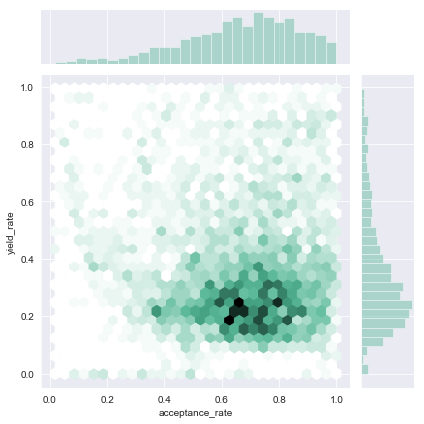

In [16]:
sns.jointplot(x = "acceptance_rate",
              y = "yield_rate",
              data = viz_set,
              kind="hex",
              color="#4CB391")

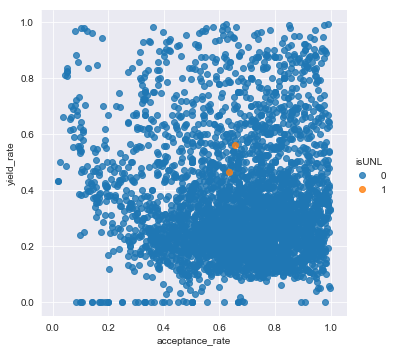

In [17]:
sns.lmplot(x = "acceptance_rate",
           y = "yield_rate",
           data = viz_set,
           fit_reg = False,
           hue='isUNL')